# Bayesian Statistic A/B Testing

This dataset comes from https://www.kaggle.com/datasets/zhangluyuan/ab-testing?select=ab_data.csv in conjunction with the Medium article https://medium.com/towards-data-science/ab-testing-with-python-e5964dd66143

The author sets up a scenario where the client is an e-commerce company with a current conversion rate of 13% and they are looking to improve their conversion by 2% to 15%. 

In [41]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# Some plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {'weight': 'bold',
        'size': 14}

mpl.rc('font', **font)

In [3]:
ab = pd.read_csv('ab_data_zhang.csv')
ab.head()


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
len(ab)

294478

## T-Test Setup

Our control group will be the old setup, and the treatment group the new setup. Since the new setup has the potential to perform better or worse than the old setup, and we are not using an inherently asymmetric distribution, a Two-Tailed T-Test is the most appropriate test for this evaluation. 

The Null Hypothesis will suggest that there is no difference between the conversion rates of the treament and that of the control. 

**Establishing Parmeters**
p = control group conversion rate
po = treatment group conversion rate

Ho: p = po, the null hypothesis states that there is no difference between the conversion rates 
Ha: p <> po, the alternative hypothesis states that there is a difference between the conversion rates. 


alpha = 0.05, per convention, this gives the probability of a Type I Error (false positive)
beta = 0.8, per convention, this gives the probability of a Type II Error (false negative)

--- 
### Power Analysis
Starting with Effect Size

In [6]:
effect_size = sms.proportion_effectsize(0.13, 0.15)
effect_size

-0.0576728617308947

In [8]:
required_n = sms.NormalIndPower().solve_power(
    effect_size,
    power=0.8,
    alpha=0.05,
    ratio=1   # This provides the ratio of the number values in sample 2 to those in sample 1. A ratio of 1 means there is the same number of each.  
)

required_n = ceil(required_n)  # ceil is the ceiling function; it rounds up to the next whole number
print(f'There are {required_n} observations in each group to be 80% confident that there is a 2% difference between the two groups.')


There are 4720 observations in each group to be 80% confident that there is a 2% difference between the two groups.


## Cleaning the Data
Addressing the following concerns: 
- Null values
- Erroneous labeling with control/treatment and the incorrect page
- Multiple user entries
We need to be sure that there aren't any null values present in the necessary rows. Additionally, we need to ensure that the control group values are indeed the old page, and the treatment values are all referencing the new page. Finally, I want to ensure that we don't have users with multiple entries. I'm saving this for last, because it's possible that a user may have entered information incorrectly and then made a correction, so to preserve as much data as possible, I will remove the erroneous data instead of that entire user's duplicates prior to determining duplicates. While both will result in the removal of erroneous and duplicate entries, more good data is lost when the multiple users are removed first. 

In [11]:
print(f'Groups: {sum(ab.group.isna())}, Landing Page: {sum(ab.landing_page.isna())}, Converted: {sum(ab.converted.isna())}')


Groups: 0, Landing Page: 0, Converted: 0


None of the groups have null values present. I can use a cross-tab to check if there are mixed values. We expect there to be 0 old_page in the treatment and 0 new_page in the control

In [12]:
pd.crosstab(ab['group'], ab['landing_page'])


landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


This is a problem! Since we cannot determine whether the mismarking was of the page or the treatment, we will remove these values from the dataset prior to sampling. I can only do this because the dataset is substantially larger than the amount of data we're removing. 

In [14]:
print(f'The number of mismarked samples represent {round((1928 + 1965)/len(ab) * 100, 2)}% of the total dataset')


The number of mismarked samples represent 1.32% of the total dataset


In [24]:
ab = ab.loc[((ab.group == 'control') & (ab.landing_page == 'old_page')) | ((ab.group == 'treatment') & (ab.landing_page == 'new_page'))]


In [25]:
pd.crosstab(ab['group'], ab['landing_page'])


landing_page,new_page,old_page
group,,
control,0,145274
treatment,145311,0


This verifies that the anomalies have been removed. Additionally, we need to verify that no users were counted multiple times. 

In [26]:
user_counts = ab['user_id'].value_counts(ascending=False)
multi_users = user_counts[user_counts > 1].count()

print(
    f'There are {multi_users} users that appear multiple times in the dataset, representing {round(multi_users/len(ab)* 100, 2)}% of the dataset')


There are 1 users that appear multiple times in the dataset, representing 0.0% of the dataset


The first time I ran this before removing the mismarked users above, and there was a suspiciously similar number of mismarked rows. At this point, there is only 1, which will not substantially impact the dataset. But to keep the cleaning applicable for potential future data entries, I'll set it up programmatically instead of just removing the single row.

In [27]:
users_to_drop = user_counts[user_counts > 1].index

ab = ab[~ab['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {ab.shape[0]} entries')


The updated dataset now has 290583 entries


### Sampling
The power analysis suggested that each group have a sample size of 4720. I'm just using the pandas df.sample to pull samples here since we're not creating any kind of fancy train/test sets for machine learning. After creating the samples, we need to concatenate them into a new dataframe, which I will call ab_sampled.

In [29]:
random_state=22

control_sample = ab[ab['group'] == 'control'].sample(
    n=required_n, random_state=random_state)

treatment_sample = ab[ab['group'] == 'treatment'].sample(
    n=required_n, random_state=random_state)

ab_sampled = pd.concat([control_sample, treatment_sample], axis=0)
ab_sampled.reset_index(drop=True, inplace=True)


In [30]:
ab_sampled

,user_id,timestamp,group,landing_page,converted
0,864622,2017-01-07 19:35:55.115584,control,old_page,0
1,931017,2017-01-20 22:24:11.980654,control,old_page,0
2,822759,2017-01-10 19:00:45.471182,control,old_page,0
3,715765,2017-01-19 23:16:23.269389,control,old_page,0
4,666686,2017-01-23 00:08:30.152180,control,old_page,0
...,...,...,...,...,...
9435,688017,2017-01-12 11:50:30.520706,treatment,new_page,0
9436,793361,2017-01-15 17:14:40.878898,treatment,new_page,0
9437,643157,2017-01-04 02:55:40.819424,treatment,new_page,0
9438,695345,2017-01-13 20:57:14.879484,treatment,new_page,0


In [31]:
ab_sampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [33]:
ab_sampled['group'].value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

We have now verified that there are still no nulls, and that we have the expected 4720 of treatment and control in our new dataframe.

In [35]:
conversion_rates = ab_sampled.groupby('group')['converted']


# Std. deviation of the proportion
def std_p(x): return np.std(x, ddof=0)
# Std. error of the proportion (std / sqrt(n))
def se_p(x): return stats.sem(x, ddof=0)


conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')


,conversion_rate,std_deviation,std_error
group,,,
control,0.120,0.325,0.005
treatment,0.121,0.327,0.005


Text(0, 0.5, 'Converted (proportion)')

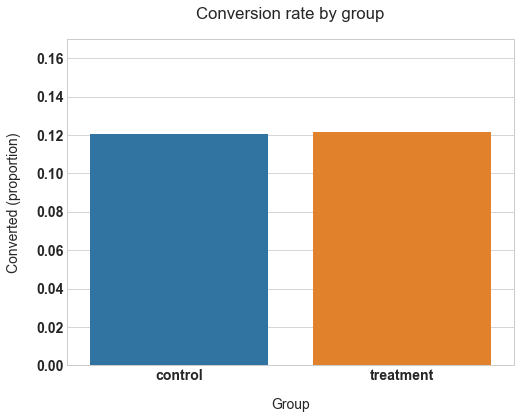

In [40]:
plt.figure(figsize=(8, 6))

sns.barplot(x=ab_sampled['group'], y=ab_sampled['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15)


## Results
Well this is fun! Either our stakeholders were overly optimistic or the random sampling somehow provided a full percentage lower than the reported 13% conversion of the control. While the treatment did perform a tiny bit better, we'll have to see whether the 0.1% difference is significant. I'm holding my breath.

This is where I'll be using the proportions Z-test and confidence interval. 

In [42]:
control_results = ab_sampled[ab_sampled['group'] == 'control']['converted']
treatment_results = ab_sampled[ab_sampled['group'] == 'treatment']['converted']


In [43]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(
    successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')


z statistic: -0.16
p-value: 0.875
ci 95% for control group: [0.111, 0.130]
ci 95% for treatment group: [0.112, 0.131]


## Conclusions
Did I mention the overly optimistic stakeholder? Perhaps the data they sampled just happened to be at the absolute top of the confidence interval, as this shows us that we are 95% confident that the true mean of the control group conversion rate lies between 11.1% and 13%, inclusive, and for our treatment group, between 11.2% and 13.1%. Needless to say, the p-value of 0.875 is not unexpected, nor is it significant, drastically failing to meet our 0.05 alpha parameter. 

Thus, we confirm our Null Hypothesis, Ho, that there is no significant difference between the conversion rates of our new landing page and the old landing page. 